In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
import random
from ipdb import set_trace as st

In [2]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

In [3]:
import sys
sys.argv=['']
del sys

In [4]:
# construct the argument parser and parser the arguments
parser = argparse.ArgumentParser(description='VAE Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=20, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

torch.manual_seed(args.seed)

# we use CPU for computation
device = torch.device("cpu")

#K = 1024
K = 100

In [5]:
def data_gen(BATCH_SIZE):
    #8 gaussians
    while 1:
        theta = (np.pi/4) * torch.randint(0, 8, (BATCH_SIZE,)).float().to(device)
        centers = torch.stack((torch.cos(theta), torch.sin(theta)), dim = -1)
        noise = torch.randn_like(centers) * 0.1
        yield centers + noise


In [6]:
test_loader = train_loader = data_gen(args.batch_size)

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x):
        h1 = F.selu(self.fc1(F.selu(self.fc0(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(z)))))

#    def decode(self, z):
#        h = F.relu(self.fc3(z))
#        mu = self.fc4(h)
#        logvar = self.fc5(h)
#        return mu, logvar

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu, logvar)
     #   mu_x, logvar_x = self.decode(z)
        return self.decode(z), mu, logvar



In [8]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose = True, threshold = 1E-2, eps=1e-6)

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    #BCE = F.binary_cross_entropy(recon_x, x.view(-1, 2), reduction='sum')
    L2 = torch.mean((recon_x-x)**2)
    # neg log likelihood of x under normal
  #  loss_rec =  np.log(2.0 * np.pi) + logvar_x + (x - mu_x)**2 / (2*torch.exp(logvar_x))
 #   loss_rec = -torch.sum((-0.5 * np.log(2.0 * np.pi))+ (-0.5 * logvar_x)+ ((-0.5 / torch.exp(logvar_x)) * (0 - mu_x) ** 2.0))
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 + KLD

Apply KernelDensity Estimation on recon_batch

In [21]:
def train(epoch):
    model.train()
    train_loss = 0
 #   train_likli = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break #100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        recon_batch = recon_batch.detach().numpy()
        kde_skl = KernelDensity(kernel='gaussian', bandwidth=0.2)
        kde_skl.fit(recon_batch)
        # score_samples() returns the log-likelihood of the samples
        log_pdf = kde_skl.score_samples(recon_batch)
        log1 = np.exp(log_pdf)
       
        loss.backward()
     #   liklihood.backward()
        train_loss += loss.item()
     #   train_likli += liklihood.item()
        optimizer.step()
    train_loss /= 100
  #  train_likli /= 100
    scheduler.step(train_loss)
    print ("Epoch  average reconstruction error   :" ,epoch ,  train_loss )
    print (" likelihood  :", log_pdf )
    print (" np.exp(likelihood ) :", log1 )

In this section, I considered the recon_batch as input KernelDensity Estimation, and since the printed results are cluttered, for clarifying the first number is Epoch, the second number is reconstruction error, the third array is log_pdf(likelihood), and the fourth array is np.exp(log_pdf).

Epoch  average reconstruction error   : 1 0.07254372511059046
 likelihood  : [-1.24921539 -1.13480127 -1.30841906 ... -1.27610134 -1.25918616
 -1.51330457]
 np.exp(likelihood ) : [0.28672968 0.321486   0.27024696 ... 0.27912339 0.28388497 0.22018117]
Epoch  average reconstruction error   : 2 0.05191675685346127
 likelihood  : [-1.20626456 -1.46026546 -1.19004023 ... -1.55398222 -1.12497209
 -1.11483718]
 np.exp(likelihood ) : [0.29931326 0.23217463 0.30420903 ... 0.21140444 0.32466153 0.32796867]
Epoch  average reconstruction error   : 3 0.05115098807960749
 likelihood  : [-1.54269371 -1.74931236 -1.49469528 ... -1.42355209 -1.09907625
 -1.15401448]
 np.exp(likelihood ) : [0.2138044  0.17389348 0.22431695 ... 0.24085695 0.33317872 0.31536819]
Epoch  average reconstruction error   : 4 0.05049796566367149
 likelihood  : [-2.74726021 -1.19419008 -1.10077137 ... -1.29784353 -2.15875771
 -1.3514893 ]
 np.exp(likelihood ) : [0.06410325 0.30294922 0.33261442 ... 0.27312013 0.11546848 0.258854

__main__:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


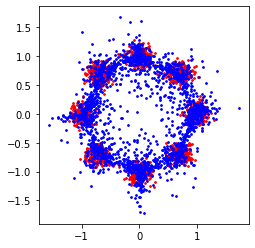

--Return--
None
> <ipython-input-22-87c6826d76cb>(25)<module>()
     23     plt.show()
     24 
---> 25     st()



In [ ]:
# k = 100
if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)

    gt = next(train_loader)
        
    with torch.no_grad():
        sample = torch.randn(2048, K).to(device)
        out = model.decode(sample).cpu().numpy()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out[:,0], out[:,1]

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
    st()

Apply KeernelDensity Estimation on final training sample( out = model.decode(sample).cpu().numpy())

In [13]:
def train(epoch):
    model.train()
    train_loss = 0
 #   train_likli = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break #100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
    #    recon_batch = recon_batch.detach().numpy()
        
       
        loss.backward()
     #   liklihood.backward()
        train_loss += loss.item()
     #   train_likli += liklihood.item()
        optimizer.step()
    train_loss /= 100
  #  train_likli /= 100
    scheduler.step(train_loss)
    print ("Epoch  average reconstruction error  :" ,epoch ,  train_loss)

Epoch  average reconstruction error  : 1 0.0785090210288763
Epoch  average reconstruction error  : 2 0.05342250294983387
Epoch  average reconstruction error  : 3 0.05112326592206955
Epoch  average reconstruction error  : 4 0.05048686489462852
Epoch  average reconstruction error  : 5 0.04987835727632046
Epoch  average reconstruction error  : 6 0.04928202982991934
Epoch  average reconstruction error  : 7 0.04846401024609804
Epoch  average reconstruction error  : 8 0.04775190629065037
Epoch  average reconstruction error  : 9 0.04704788498580456
Epoch  average reconstruction error  : 10 0.04603423252701759
Epoch  average reconstruction error  : 11 0.04519266664981842
Epoch  average reconstruction error  : 12 0.04430767185986042
Epoch  average reconstruction error  : 13 0.043535117618739606
Epoch  average reconstruction error  : 14 0.04295987837016582
Epoch  average reconstruction error  : 15 0.0425436244904995
Epoch  average reconstruction error  : 16 0.04229935616254807
Epoch  average rec

__main__:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


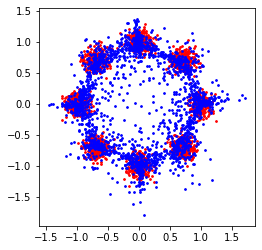

--Return--
None
> <ipython-input-14-f5c89cc5a9bc>(31)<module>()
     29     plt.show()
     30 
---> 31     st()



In [ ]:
# k = 100
if __name__ == "__main__":
    for epoch in range(1, args.epochs + 1):
        train(epoch)

    gt = next(train_loader)
        
    with torch.no_grad():
        sample = torch.randn(2048, K).to(device)
        out = model.decode(sample).cpu().numpy()
        recon = model(gt)[0].cpu().numpy()

    rx,ry = recon[:,0], recon[:,1]
        
    gt = gt.cpu().numpy()
    gx, gy = gt[:,0], gt[:,1]
        
    xs, ys = out[:,0], out[:,1]
    kde_skl = KernelDensity(kernel='gaussian', bandwidth=0.2)
    kde_skl.fit(out)
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(out)
    log1 = np.exp(log_pdf)
    print("log likelihood: " ,log_pdf, log1)

    plt.scatter(gx, gy, c = 'red', s=3)
    plt.scatter(xs, ys, c = 'blue', s=3)
    plt.axes().set_aspect('equal')
    plt.show()
    
    st()